# Change in annual total precipitation, liquid precipitation and snowfall between 1979 to 1988 and 2014 and 2023.

## Overview

I use ERA5 monthly precipitation accumulations to examine the change in annual precipitation between two decades at the beginning of the satellite period in ERA5 reanalysis and the present day.  

## Data

I use monthly fields of total precipitation and snowfall from the ERA5 Reanalysis.  Monthly fields of accumulated fields such as precipitation are expressed as daily averages for each month.  To calculate monthly precipitation sums, daily averages for each month need to be multiplied by the number of days in that month.  As we use annual accumulations, monthly fields for each year are summed and multipled by 30.4 (e.g. $\frac{365}{12}$).

ERA5 data are downloaded from the Copernicus Climate Change Service (2023), ERA5 monthly averaged data on single levels from 1940 to present. (Copernicus Climate Change Service (C3S) Climate Data Store (CDS). DOI: 10.24381/cds.f17050d7 (Accessed on 2025-10-01)).

Liquid precipitation is not available as variable.  Liquid precipitation is calculated as the difference between Total Precipitation (`tp`) and Snowfall (`sf`).

Data analysis and plots are performed using the Python xarray, Matplotlib and Cartopy packages.

In [1]:
from pathlib import Path

import xarray as xr

import matplotlib.pyplot as plt
import cartopy.crs as ccrs

DATAPATH = Path.home() / "Data" / "ERA5" / "single_level" / "monthly"
FILEPATH = DATAPATH / "era5.monthly.precipitation.nc"

# Analysis Workflow

Data are loaded using `xarray.open_dataset`.

In [2]:
ds = xr.open_dataset(FILEPATH, drop_variables=["number", "expver"])
ds

<xarray.Dataset> Size: 5GB
Dimensions:     (valid_time: 557, latitude: 721, longitude: 1440)
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 4kB 1979-01-01T06:00:00 ... 2025-...
  * latitude    (latitude) float64 6kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude   (longitude) float64 12kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
Data variables:
    tp          (valid_time, latitude, longitude) float32 2GB ...
    sf          (valid_time, latitude, longitude) float32 2GB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-06-27T22:43 GRIB to CDM+CF via cfgrib-0.9.1...

We subset the data to the 1979 to 2023 period

In [3]:
ds = ds.sel(valid_time=slice("1979","2023"))

Annual totals of total precipitation and snowfall are calculated by multiplying monthly values, which are average daily precipitation for the month, by the number of days in each month, and then summing.

$$
\begin{align}
tp_{ann} = \sum_{m=1}^{12} tp_{mon} * n_m
\end{align}
$$

In [4]:
ds = ds * ds.valid_time.dt.daysinmonth  # Convert from average daily P to month total
ds = ds.resample(valid_time="YS").sum()

Liquid precipitation is calculated as the difference between total precipitation (`tp`) and snowfall (`sf`).

In [5]:
ds["lp"] = ds.tp - ds.sf
ds.lp.attrs = {
    "long_name": "liquid precipitation",
    "units": "m",
}
ds

<xarray.Dataset> Size: 1GB
Dimensions:     (valid_time: 45, latitude: 721, longitude: 1440)
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 360B 1979-01-01 ... 2023-01-01
  * latitude    (latitude) float64 6kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude   (longitude) float64 12kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
Data variables:
    tp          (valid_time, latitude, longitude) float64 374MB 0.2225 ... 0....
    sf          (valid_time, latitude, longitude) float64 374MB 0.1795 ... 0....
    lp          (valid_time, latitude, longitude) float64 374MB 0.043 ... -5....

To evaluate change in precipitation fields we calculate the difference between the 2014 to 2023 and 1979 to 1988 periods.

In the paper we use 1979 to 1989 and 2013 to 2023, which are 11 year periods rather than 10 years.  This does not make much of a difference.

In [6]:
ds_period_early = ds.sel(valid_time=slice("1979","1989")).mean(dim="valid_time")
ds_period_late = ds.sel(valid_time=slice("2013","2023")).mean(dim="valid_time")
ds_diff = (ds_period_late - ds_period_early)
ds_diff

<xarray.Dataset> Size: 25MB
Dimensions:    (latitude: 721, longitude: 1440)
Coordinates:
  * latitude   (latitude) float64 6kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float64 12kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
Data variables:
    tp         (latitude, longitude) float64 8MB 0.01324 0.01324 ... 0.003484
    sf         (latitude, longitude) float64 8MB 0.0145 0.0145 ... 0.00355
    lp         (latitude, longitude) float64 8MB -0.001268 ... -6.626e-05

In [7]:
print(f"Minimum difference: {ds_diff.lp.sel(latitude=slice(90,60)).min().values}")
print(f"Maximum difference: {ds_diff.lp.sel(latitude=slice(90,60)).max().values}")

Minimum difference: -0.1726524829864502
Maximum difference: 0.48361203887245874


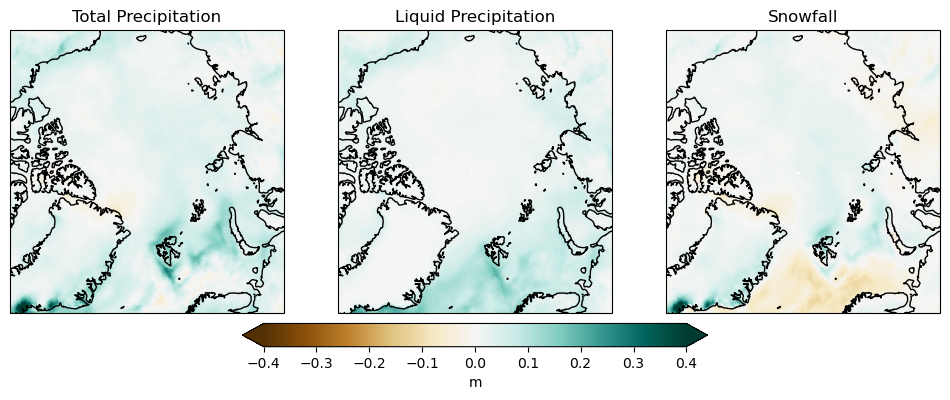

In [8]:
projection = ccrs.Orthographic(
        central_latitude=90.,
        central_longitude=0.
    )

vmin = -0.4  # ds_diff.lp.sel(latitude=slice(90,60)).min()
vmax = 0.4  #ds_diff.lp.sel(latitude=slice(90,60)).max()

extent = [-180., 180., 70., 90.]

fig = plt.figure(figsize=(12,7))

ax0 = fig.add_subplot(131, projection=projection)
ds_diff.tp.plot(
    ax=ax0,
    transform=ccrs.PlateCarree(),
    vmin=vmin, vmax=vmax,
    cmap="BrBG",
    add_colorbar=False
)
ax0.set_extent(extent, ccrs.PlateCarree())
ax0.coastlines()
ax0.set_title("Total Precipitation")

ax1 = fig.add_subplot(132, projection=projection)
ds_diff.lp.plot(
    ax=ax1,
    transform=ccrs.PlateCarree(),
    vmin=vmin, vmax=vmax,
    cmap="BrBG",
    add_colorbar=False
)
ax1.set_extent(extent, ccrs.PlateCarree())
ax1.coastlines()
ax1.set_title("Liquid Precipitation")

ax2 = fig.add_subplot(133, projection=projection)
ds_diff.sf.plot(
    ax=ax2,
    transform=ccrs.PlateCarree(),
    vmin=vmin, vmax=vmax,
    cmap="BrBG",
    add_colorbar=False
)
ax2.set_extent(extent, ccrs.PlateCarree())
ax2.coastlines()
ax2.set_title("Snowfall");

mappable = ax2.collections[0]

fig.colorbar(mappable, ax=[ax0, ax1, ax2], orientation="horizontal",
            extend="both", shrink=0.5, pad=0.02, label="m")
# plt.colorbar()

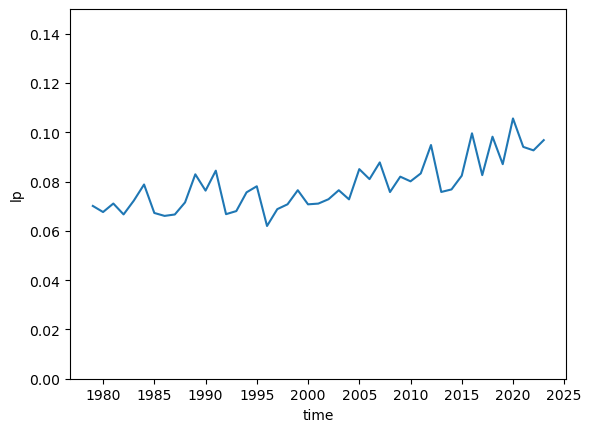

In [9]:
ds.sel(latitude=slice(90,70)).mean(dim=["latitude","longitude"]).lp.plot(ylim=(0,0.15))